In [1]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from clean import clean_and_filter_jsonl

### Filtering JSONL information against training data

In [2]:
BASE_DIR            = os.path.abspath(os.path.join(os.getcwd(), ".."))
JSONL_NAME          = os.path.join(BASE_DIR, 'Dataset', 'open_images_train_v6_localized_narratives-00000-of-00010.jsonl')
IMAGE_FOLDER_NAME   = os.path.join(BASE_DIR, 'Dataset', 'Original_train')
FILTERED_JSON_NAME  = os.path.join(BASE_DIR, 'Dataset', 'filtered_original_train.jsonl')

image_files = os.listdir(IMAGE_FOLDER_NAME)
image_list = [img for img in image_files if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Found {len(image_list)} images in Images folder.")

with open(JSONL_NAME, 'r', encoding='utf-8') as f:
    first_line = json.loads(f.readline().strip())
    print(f"Jsonl file with key: {list(first_line.keys())}")


Found 19354 images in Images folder.
Jsonl file with key: ['dataset_id', 'image_id', 'annotator_id', 'caption', 'timed_caption', 'traces', 'voice_recording']


In [3]:
filtered_entries = clean_and_filter_jsonl(
    base_dir=BASE_DIR,
    split_name='Original Train',
    image_folder_name=IMAGE_FOLDER_NAME,
    jsonl_name=JSONL_NAME,
    filtered_json_name=FILTERED_JSON_NAME
)

[Original Train] Found 19354 images.
[Original Train] Number of filtered entries: 19354


### Display length and area size distribution

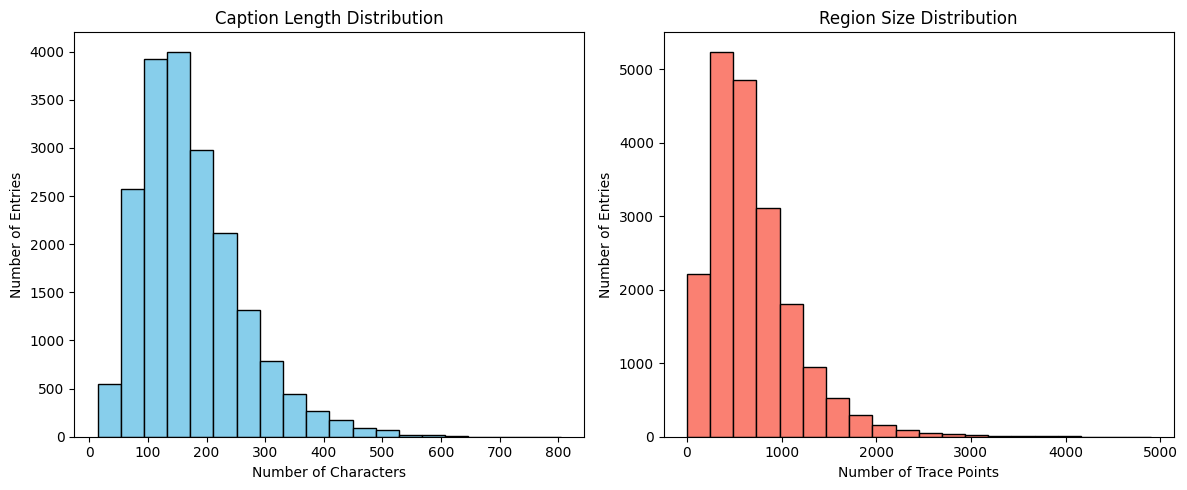

In [4]:
caption_lengths = []   
region_sizes = []     

for entry in filtered_entries:
    # Statistics caption length (number of characters)
    caption = entry.get('caption', '')
    caption_lengths.append(len(caption))

    # Sum the number of traces
    traces = entry.get('traces', [])
    total_points = sum(len(trace) for trace in traces)
    region_sizes.append(total_points)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Caption Length Distribution
axs[0].hist(caption_lengths, bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Caption Length Distribution')
axs[0].set_xlabel('Number of Characters')
axs[0].set_ylabel('Number of Entries')

# Region Size Distribution (points per entry, within first_start–last_end)
axs[1].hist(region_sizes, bins=20, color='salmon', edgecolor='black')
axs[1].set_title('Region Size Distribution')
axs[1].set_xlabel('Number of Trace Points')
axs[1].set_ylabel('Number of Entries')

plt.tight_layout()
plt.show()


### Details of the first five training data

In [5]:
entry_map = { entry['image_id']: entry for entry in filtered_entries }
image_subset = image_list[:5]

for image_name in image_subset:
    image_id = os.path.splitext(image_name)[0]
    entry = entry_map.get(image_id)
    if entry:
        for key, value in entry.items():
            if key not in ['dataset_id', 'annotator_id', 'voice_recording']:
                print(f"{key}: {value}")
        print("=" * 60)

image_id: 0000575f5a03db70
caption: In this image there is a car on a ground, in the background there are people standing, few are sitting and there are trees, poles.
timed_caption: [{'utterance': 'In', 'start_time': 0.0, 'end_time': 0.5}, {'utterance': 'this image there is', 'start_time': 0.5, 'end_time': 0.8}, {'utterance': 'a car', 'start_time': 0.8, 'end_time': 1.7}, {'utterance': 'on', 'start_time': 3.4, 'end_time': 4.2}, {'utterance': 'a ground, in', 'start_time': 4.2, 'end_time': 4.4}, {'utterance': 'the', 'start_time': 4.4, 'end_time': 5.6}, {'utterance': 'background', 'start_time': 5.6, 'end_time': 7.2}, {'utterance': 'there are', 'start_time': 7.2, 'end_time': 7.2}, {'utterance': 'people', 'start_time': 7.2, 'end_time': 8.5}, {'utterance': 'standing,', 'start_time': 8.5, 'end_time': 9.5}, {'utterance': 'few', 'start_time': 9.5, 'end_time': 12.3}, {'utterance': 'are', 'start_time': 12.3, 'end_time': 12.4}, {'utterance': 'sitting', 'start_time': 12.4, 'end_time': 12.7}, {'utter

### Trajectory Display

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_52104\2771302365.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')


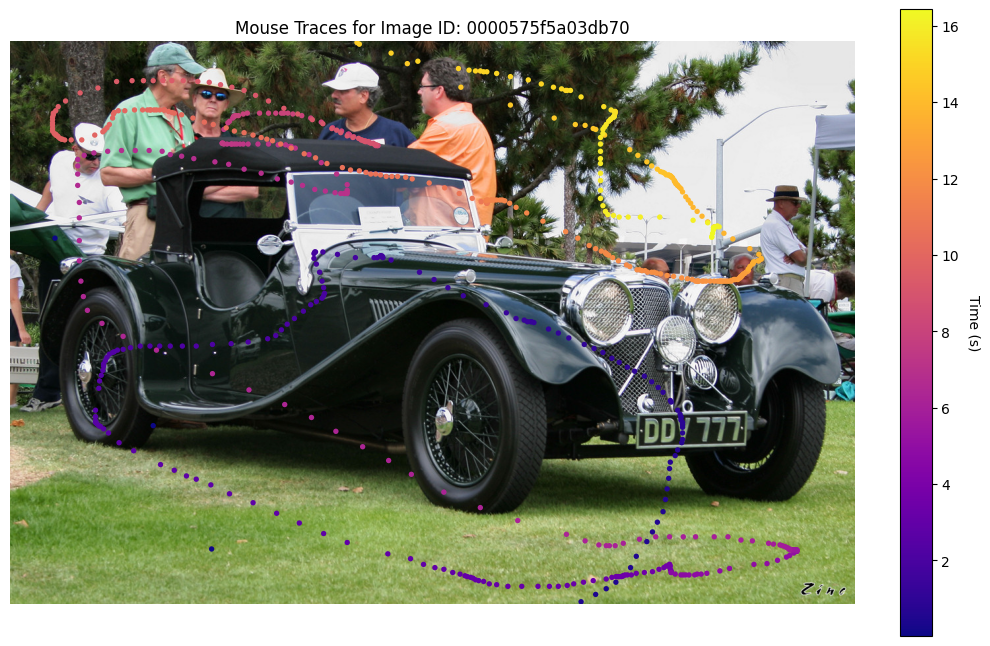

Caption: In this image there is a car on a ground, in the background there are people standing, few are sitting and there are trees, poles.


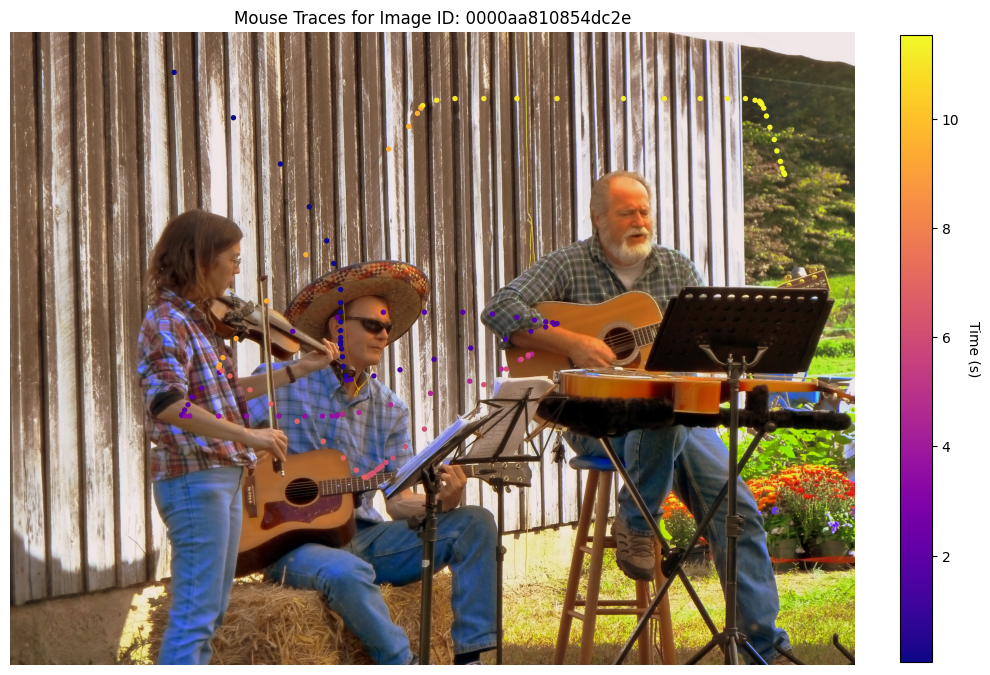

Caption: In this image there are two man and a woman,the man are holding the guitar and playing,the woman is playing the musical instrument,at the background i can see a shed and a tree.


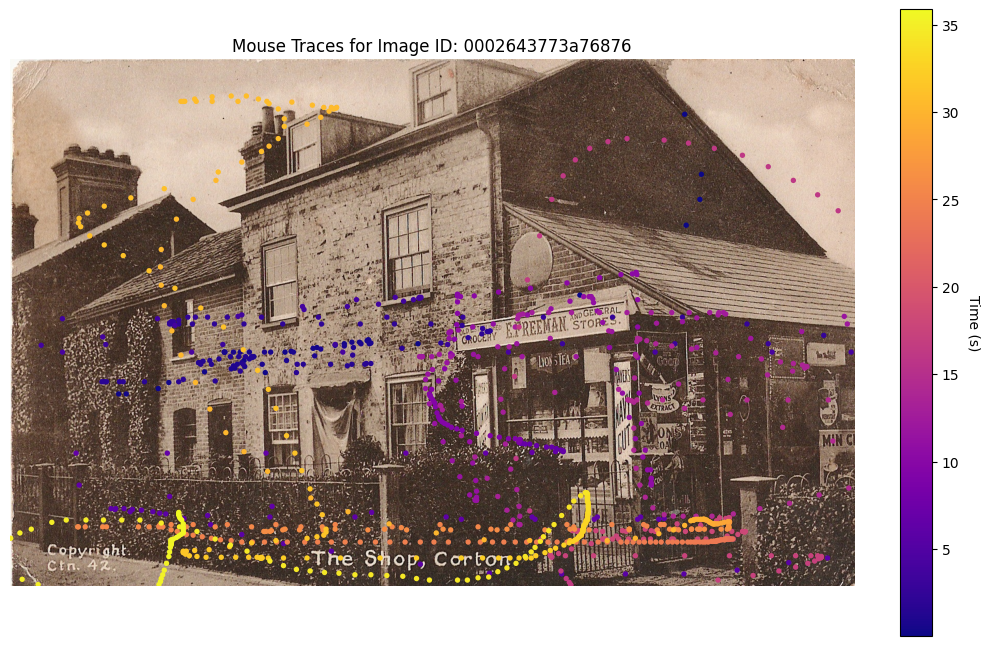

Caption: This is an edited picture. In this image there are buildings and there are plants and there are boards on the buildings and there is text on the boards. In the foreground there is a railing. At the top there is sky. At the bottom there is text. At the bottom left there is text.


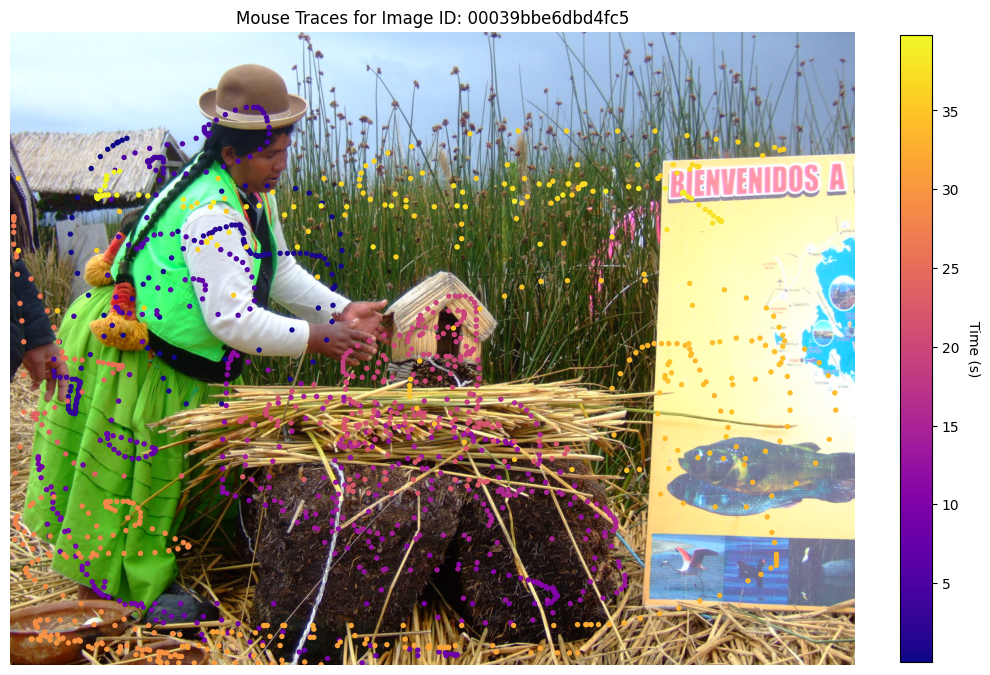

Caption: In this image there is a lady wearing hat on her head and she is standing on the surface of the dry grass, in front of her there is an object on which there is a toy house and grass are placed, there are few objects and a banner on the surface of the grass. In the background there is a hut, grass and the sky.


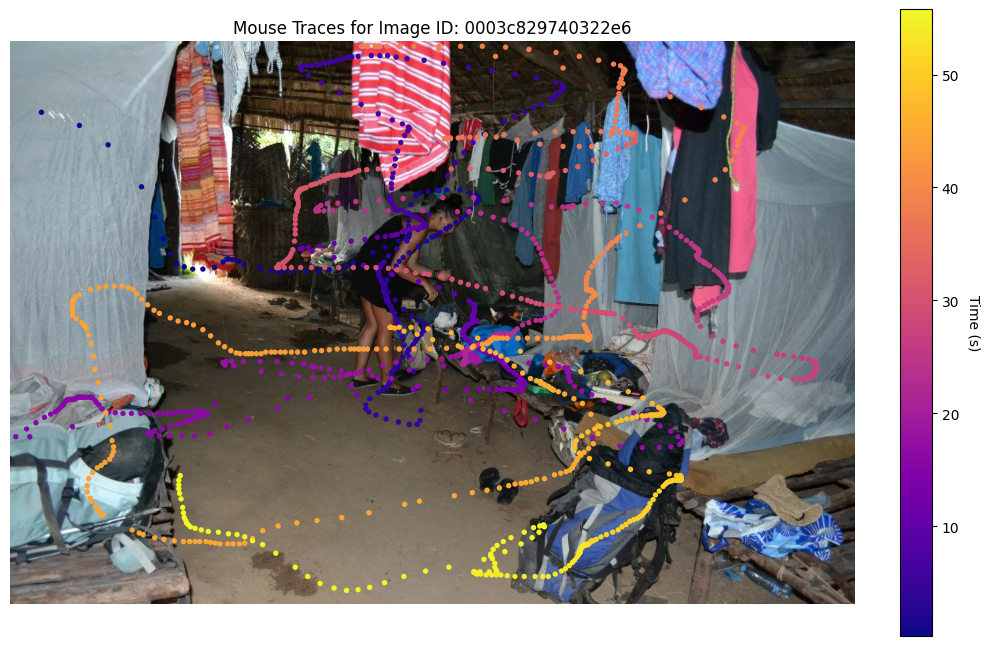

Caption: A woman is standing in a house. There are some cuts on either side. There are mosquito nets on the cots. There are clothes hanged from the ropes tied to the roof. There are clothes scattered on the cots. There are bags and other articles on the ground.


In [6]:
for image_name in image_subset:
    image_id = os.path.splitext(image_name)[0]
    entry = entry_map.get(image_id)

    if entry is None:
        print(f"[WARNING] Image ID {image_id} not found in entry_map.")
        continue

    traces = entry['traces']
    caption = entry.get('caption', 'N/A')

    # Reads and displays the basemap
    image_path = os.path.join(IMAGE_FOLDER_NAME, f"{image_id}.jpg")
    image = Image.open(image_path)
    width, height = image.size

    # Process all trace points
    all_points = []
    for trace in traces:
        for point in trace:
            x_pixel = point['x'] * width
            y_pixel = point['y'] * height
            t = point['t']
            all_points.append((t, x_pixel, y_pixel))

    if not all_points:
        print(f"[WARNING] No trace points for {image_id}.")
        continue

    # Sort by “time t”
    all_points.sort(key=lambda tup: tup[0])
    times = [tup[0] for tup in all_points]      
    xs    = [tup[1] for tup in all_points]      
    ys    = [tup[2] for tup in all_points]      

    norm = mcolors.Normalize(vmin=min(times), vmax=max(times))
    cmap = cm.get_cmap('plasma')

    plt.figure(figsize=(10, 8))
    plt.imshow(image)

    # Showing time track by color shades
    scatter = plt.scatter(
        xs, ys,
        c=times,
        cmap=cmap,
        norm=norm,
        s=15,       
        edgecolors='none' 
    )

    # Add colorbar and caption
    cbar = plt.colorbar(scatter, fraction=0.034, pad=0.05)
    cbar.set_label('Time (s)', rotation=270, labelpad=15)

    plt.title(f"Mouse Traces for Image ID: {image_id}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Caption: {caption}")
    print("=" * 60)
